# Adaptive Frank-Wolf method for Relative-Error problems
## Problem formulation

PageRank[1] problem for Frank-Wolf methods is shown below:

$$
f(x) = \frac{1}{2}\left\lVert{Ax}\right\rVert_2^2 \to \min_{x\in\Delta^n_{1}}
$$

, where:

$$
A = I - P^\intercal
$$

$I$ – identity matrix of size $n\times n$, $P$ – stochastic transit matrix, $P \in \R^{n\times n}$

Gradient of the given function is represented below:

$$
\nabla f(x) = A^\intercal A x
$$

[1]: Efficient numerical methods to solve sparse linear equations with application to PageRank, Anikin A., Gasnikov A., et al, 2022


#  Implementation of Adaptive Frank-Wolfe algorithm with Erroneous Conditional Oracle

In [64]:
import numpy as np

# Visualization
import matplotlib.pyplot as plt

In [65]:
from aecg import AECG, ECG
from helper import Objective, PageRankObjective
from helper import BoxSetLMO
from helper import CWEOracle
from helper import StepSizeStrategy

# Configure `seed` for reproducibility of the solution
np.random.seed(2025)

# Size of the problem
n = 100

# Relative Error [0; 0.5)
eps = 0.3

# Objective parameters
A = np.random.randn(n, n)
A = A / A.sum(axis=1, keepdims=True)  # Normalize rows for PageRank

# Box Set properties
lower_bound = np.zeros(n)
upper_bound = np.ones(n)

# Objective function
objective = PageRankObjective(A)

# Number of iterations
max_iterations = 150

# Coordinate-wise erroneous oracle
erroneous_oracle = CWEOracle(epsilon=eps)

# Linear minimization oracle
linear_minimization_oracle = BoxSetLMO(lower_bound=lower_bound, upper_bound=upper_bound)

# Starting point
w0 = np.random.uniform(lower_bound, upper_bound)

# M
M = 150

# R
R = 200

# Lipschitz-gradient constant
L = np.linalg.eigvals(A).max()
L


def create_ecg_algorithm(label: str, is_bounded: StepSizeStrategy) -> ECG:
    return ECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        epsilon=eps,
        keep_history=True,
        is_bounded=is_bounded,
        M=M,
        R=R,
    )


# Helper function for creating algorithm with given step size.
def create_adaptive_algorithm(label: str, step_size: StepSizeStrategy) -> AECG:
    return AECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        step_size=step_size,
        keep_history=True,
    )

## Scenario with iteration-dependent step-size.

Let the-step size is dependent on iteration number $t$:

$$
\eta_t = \frac{2}{t + 2}, \forall t \geqslant 0
$$

## Unbounded $L_t$

$$
L_t = \frac{2 \cdot \Bigl(f^{t+1} - f^t - {\eta_t\langle \hat{g^t}, p^{t+1} \rangle}\Bigr)}{\eta_t^2\lVert p^{t + 1}\rVert^2}\\
f^t - f^* \leqslant \varepsilon M R + \frac{4 L_t \cdot R^2}{t + 2}\\
f^{t+1} - f^* \leqslant \varepsilon M R + \frac{t+1}{(t + 2)^2}4 L_t \cdot R^2\\
$$

## Bounded $L_t$

$$
L_t = \frac{2 \cdot \Bigl(f^{t+1} - f^t - {\eta_t\langle \hat{g^t}, p^{t+1} \rangle} - \eta_t \varepsilon M R\Bigr)}{\eta_t^2\lVert p^{t + 1}\rVert^2}\\
f^t - f^* \leqslant 2 \varepsilon M R + \frac{4 L_t \cdot R^2}{t + 2}\\
f^{t+1} - f^* \leqslant 2\varepsilon M R + \frac{t+1}{(t + 2)^2}4 L_t \cdot R^2\\
$$

# Scenario with L-smoothness constant dependent step-size

$$
\eta_t = -\frac{\langle\hat{g}^t, p^{t+1}\rangle}{L_t ||p^{t+1}||^2}
$$

## Unbounded $L_t$

$$
f^{t+1} − f^t \leqslant −\frac{\langle \hat{g}^t, p^{t+1} \rangle^2}{2L_t||p^{t+1}||^2}
$$

## Bounded $L_t$

$$
f^{t+1} − f^t \leqslant −\frac{\langle \hat{g}^t, p^{t+1} \rangle(\frac{1}{2}\langle \hat{g}^t, p^{t+1} \rangle + \varepsilon M R)}{2L_t||p^{t+1}||^2}
$$

In [66]:
non_adaptive_algorithms = [
    create_ecg_algorithm(label, is_bounded)
    for label, is_bounded in [
        (r"ECG with Adaptive Unbounded $L_t$", False),
        (r"ECG with Adaptive Bounded $L_t$", True),
    ]
]

In [67]:
# Solve for iteration dependent step size
from helper import LtDependentStepSizeStrategy


class StepSizeWrapper:
    """
    A wrapper for |DecayingStepSizeStrategy| to print table of
    intermediate results.
    """

    _L: float
    _wrappee: StepSizeStrategy

    def __init__(self, wrappee: StepSizeStrategy, L: float):
        self._wrappee = wrappee
        self._L = L
        self._print_table(r"$    t     L_t    L$")

    def __call__(
        self,
        t: int,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> float:
        return self._wrappee(t, g_hat, p)

    def adjust(self):
        self._wrappee.adjust()

    def adapt(self):
        self._wrappee.adapt()

    def is_adapted(
        self,
        t: int,
        objective: Objective,
        w: np.ndarray,
        w_next: np.ndarray,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> bool:
        result = self._wrappee.is_adapted(t, objective, w, w_next, g_hat, p)
        self._print_table(f"{t:6d} {self._wrappee._Lt:10.3e} {self._L:10.1f}")
        return result

    def _print_table(self, row: str):
        if False:
            print(row)

In [68]:
adaptive_algorithms = [
    create_adaptive_algorithm(
        label=label,
        step_size=StepSizeWrapper(
            LtDependentStepSizeStrategy(eps, L, M, R, is_bounded=is_bounded), L
        ),
    )
    for label, is_bounded in [
        (r"Adaptive ECG with Unbounded $L_t$", False),
        (r"Adaptive ECG with Bounded $L_t$", True),
    ]
]

## Results

# Iteration-dependent step-size

g_hat=array([  3278.75307475,    603.51843316,    192.65509755,  12025.05720046,
       -15360.48440546,   -738.37266661,   8651.3126227 ,   4208.84552192,
         -697.79260061,   -858.79792631,  -4956.41009969,  -2233.10364618,
        13978.25516092,  -2653.55496715,   -105.72054032,  -3616.47422501,
        -5402.58470941,   7876.86623807,  -3908.37472795,  16664.77573799,
        -7825.73019316,  -6234.35084343,   1855.9049204 ,   3312.42203106,
        -3232.32330802,    221.77544226,   2166.6414031 ,   1306.53025553,
        -2581.13399499,   4474.59669775,    771.44195412,  -8806.73764767,
         -780.96862856,   4596.12802769,  -2852.39074336,  -4335.9389541 ,
         6239.44975507,   7991.83060149,   4445.33344181,   -752.39203149,
          904.77565229,   4076.93422712,  -2285.84955793, -13548.30502976,
        14157.68589638,  -3341.84098657,    387.06182694,  -1069.27494889,
         1682.42230875,  -1733.36713511,   8456.14661117,  -4181.32446467,
        -4262.82215

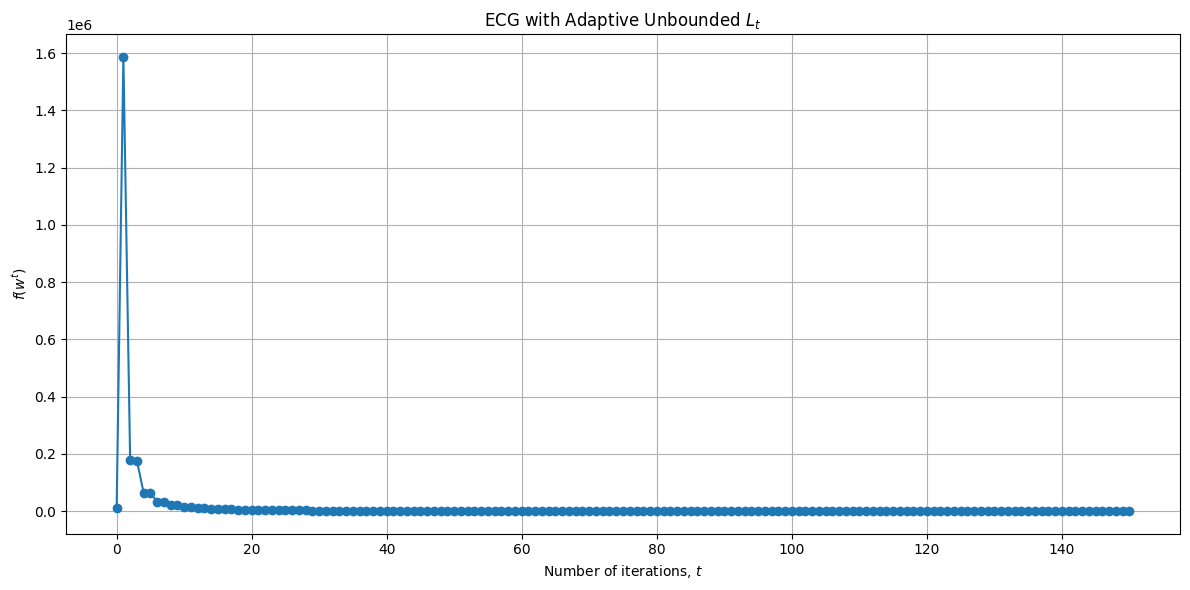

g_hat=array([  3143.4901301 ,    579.48101927,    192.0969017 ,   8372.10098511,
       -15030.83228857,   -975.29542132,   8822.97110884,   3554.62339366,
         -698.69183405,   -908.57297261,  -4783.00927816,  -1880.07679274,
        11051.92677558,  -2610.96253929,   -170.84159116,  -3246.22862238,
        -6048.02107201,  10440.18815311,  -3878.05617422,  11205.2537885 ,
       -11115.83375971,  -6338.1715745 ,   1606.30428258,   3530.85773128,
        -2234.072711  ,    272.61817056,   2347.211221  ,   1721.71342233,
        -3522.81465538,   4450.04520147,    961.36222825,  -7342.54748532,
         -778.42890359,   5515.42397289,  -3678.30085043,  -4223.78630538,
         8646.47172409,   9276.9491398 ,   7553.51501544,   -758.41352382,
          808.98221376,   5380.68155718,  -1430.0656207 , -10922.0676064 ,
        12223.7021497 ,  -4540.3025436 ,    357.82931083,   -968.05508263,
         1396.22072893,  -2631.40642188,   6944.61544322,  -3496.5237547 ,
        -4151.97849

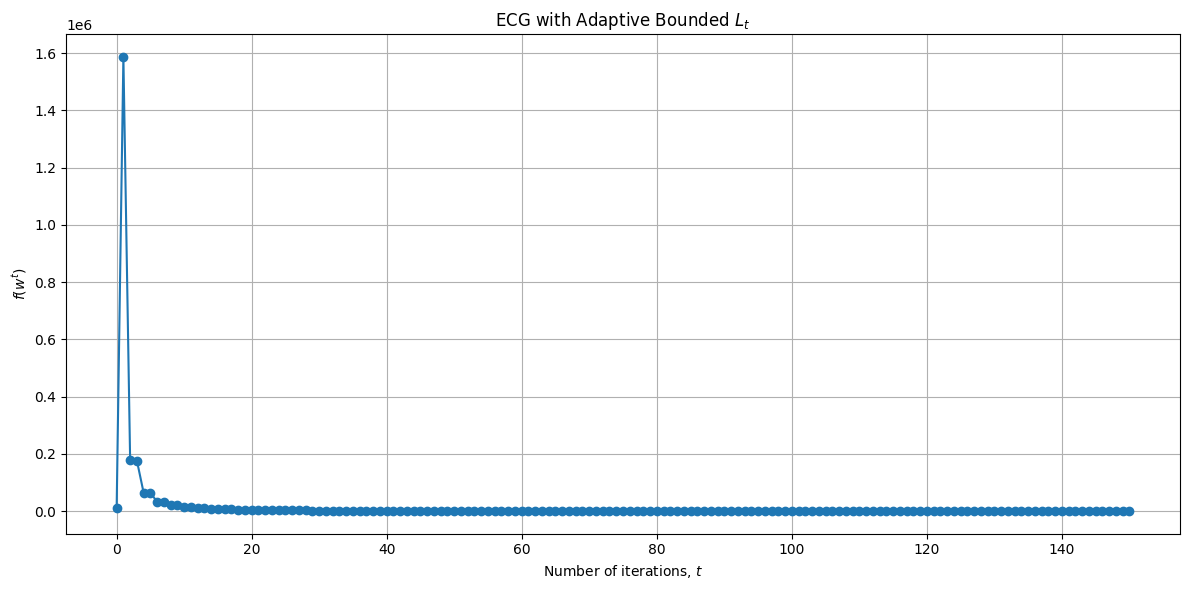

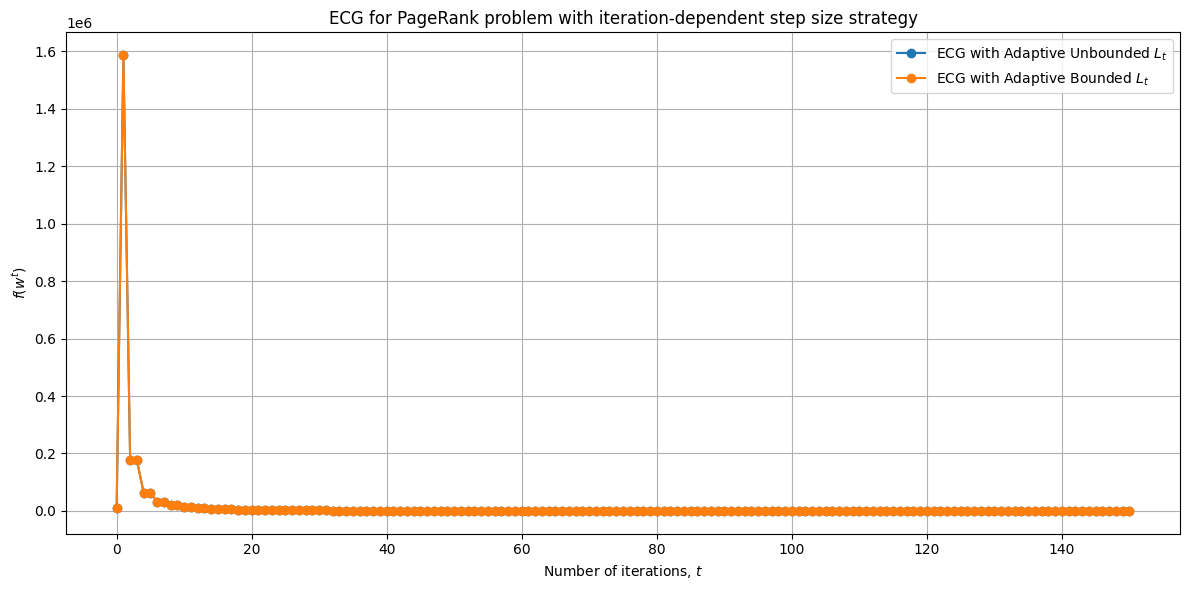

In [69]:
# Comparison of results
for algorithm in non_adaptive_algorithms:
    algorithm.solve(w0)
    plt.figure(figsize=(12, 6))
    values = [objective(w) for w, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.title(algorithm.label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
for algorithm in non_adaptive_algorithms:
    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

plt.title(r"ECG for PageRank problem with iteration-dependent step size strategy")
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$f(w^t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## $L_t$

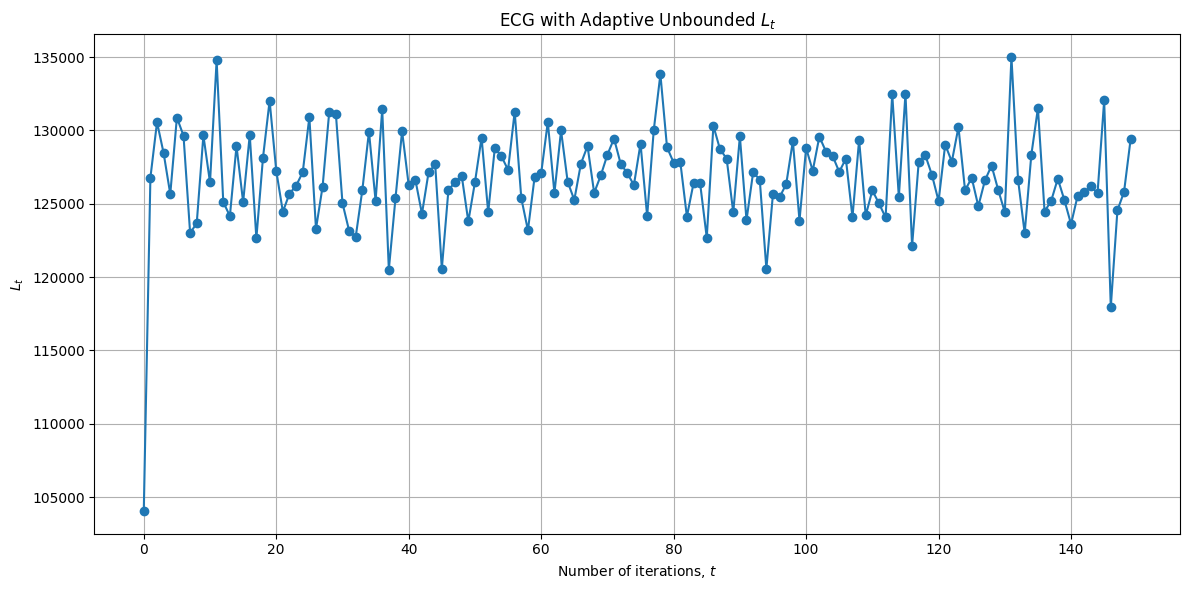

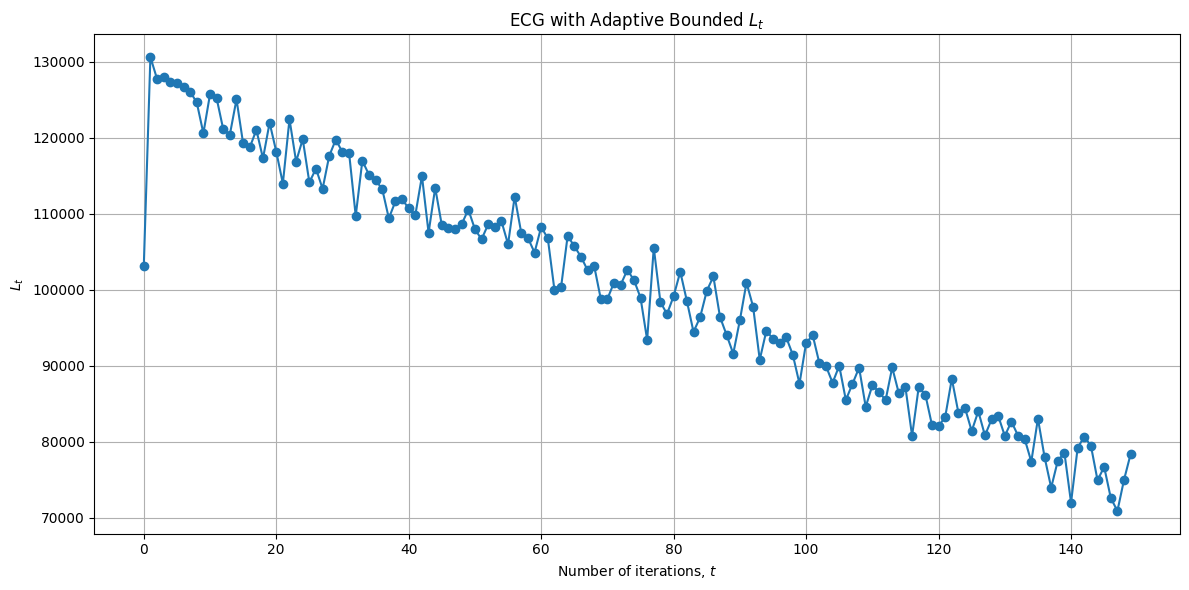

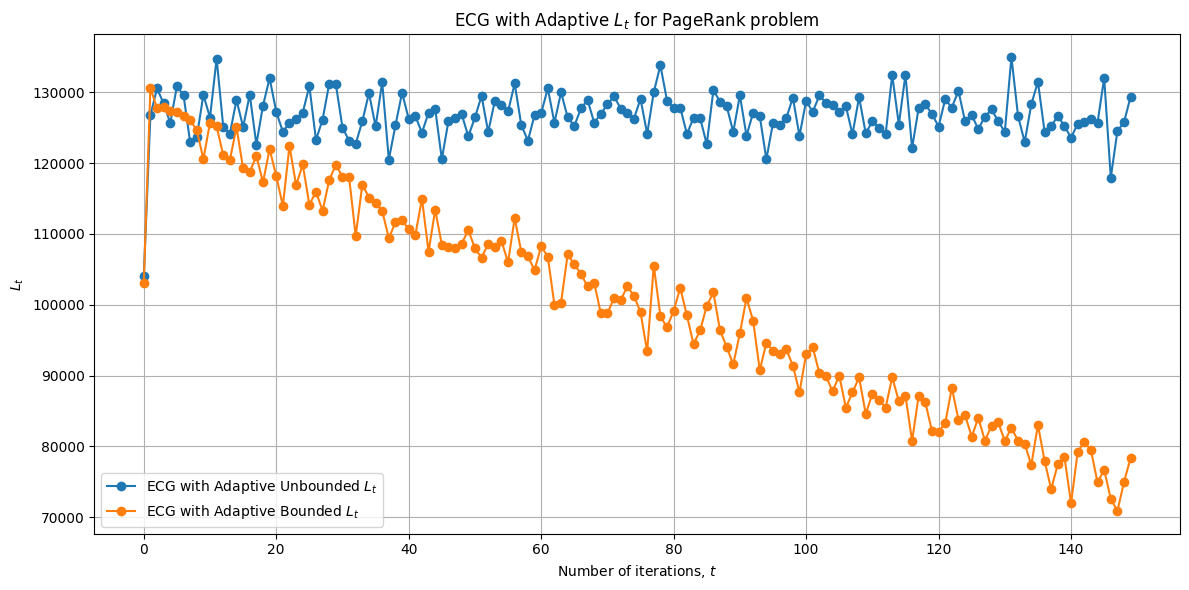

In [70]:
for algorithm in non_adaptive_algorithms:
    plt.figure(figsize=(12, 6))
    values = [Lt for Lt in algorithm.Lt]
    plt.plot(values, label=algorithm.label, marker="o")
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$L_t$")
    plt.title(algorithm.label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
for algorithm in non_adaptive_algorithms:
    values = [Lt for Lt in algorithm.Lt]
    plt.plot(values, label=algorithm.label, marker="o")

plt.title(r"ECG with Adaptive $L_t$ for PageRank problem")
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$L_t$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## L-smoothness constant-dependent step-size

g_hat=array([  4458.08942873,    821.34490974,    178.39171977,   6842.37264271,
       -15287.71227065,  -1050.90131125,   8920.62572593,   4410.58052833,
         -743.18190054,   -953.04640399,  -6661.01972906,  -2563.95679969,
        11130.57021977,  -2021.79607241,   -177.12086865,  -2443.94895331,
        -3624.04303484,   8291.11590468,  -4031.46422683,  15005.51608152,
        -9352.44692429,  -4775.69393964,   1710.83181748,   4446.90264024,
        -2520.72278027,    292.56134762,   1448.81047784,   1696.07856418,
        -3008.43727935,   4545.51354413,    824.53670909,  -5835.6153961 ,
         -987.22715404,   4380.70016969,  -3516.94704972,  -5325.04957387,
         6509.44027766,   8668.6534269 ,   6800.22385566,   -939.69410485,
          818.59024688,   6220.44765805,  -2601.16570018, -13718.13517043,
        14725.5359954 ,  -2573.35374439,    381.44873751,   -785.84328787,
         1260.68225617,  -2558.48994549,   8053.54622968,  -3828.85112976,
        -2758.97111

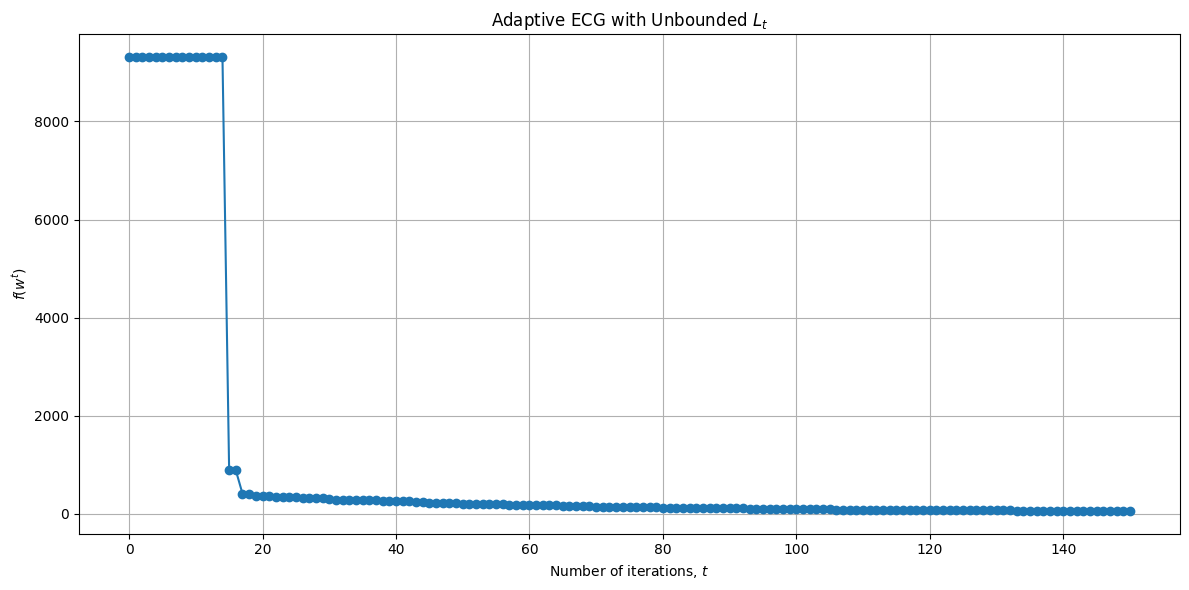

g_hat=array([  2988.68586327,    869.40416231,    166.13067156,  10451.01003609,
       -10276.94889506,   -577.83218795,   7777.97493049,   3147.06570611,
         -610.42864504,  -1307.28160645,  -6969.38855049,  -2933.3903662 ,
         9564.49987613,  -1690.07133055,   -103.94764425,  -3977.06028364,
        -6415.33078776,   7457.29604833,  -3438.37317703,  14725.37192425,
        -8838.80831667,  -6250.66103287,   1967.81453145,   5591.74340737,
        -2626.13487866,    221.09539391,   1677.42167686,   1819.15271692,
        -3492.20735383,   6486.57614199,    655.68947575,  -8760.21971103,
         -835.57237996,   5617.73576711,  -4048.36596256,  -4350.73808676,
         8124.59645956,   7482.45366374,   5632.8571006 ,   -827.45767148,
          706.56338516,   4486.19359632,  -2238.29860657, -13895.77520577,
         8941.13391981,  -2905.48440641,    314.84706293,   -946.10880418,
         1784.61759526,  -2467.9940279 ,   8398.06200671,  -4218.24449139,
        -4491.58825

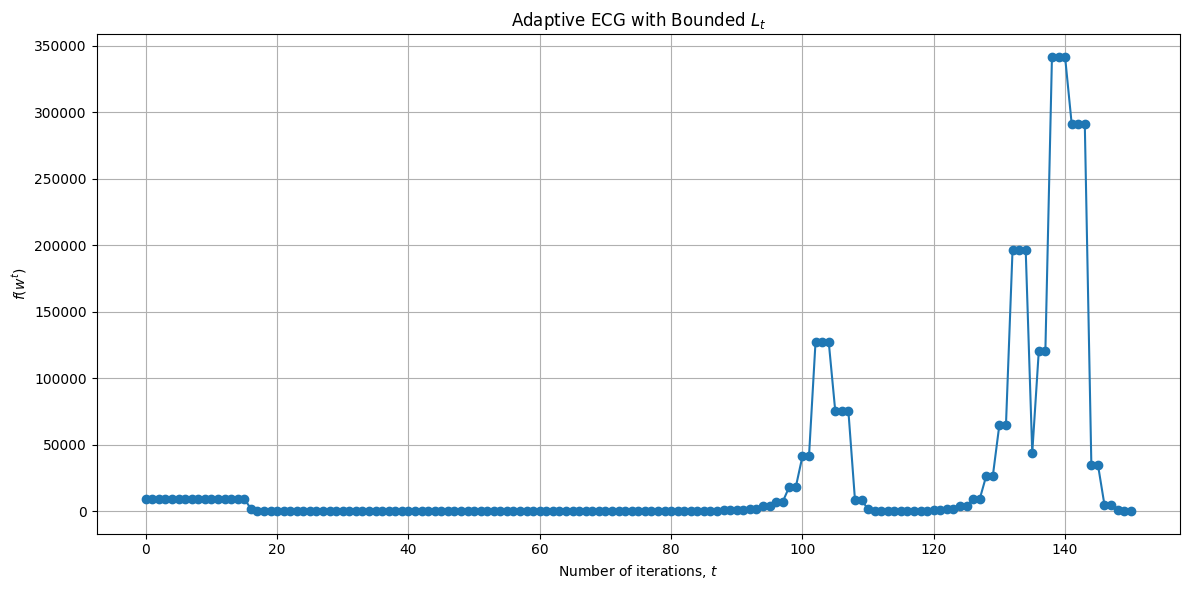

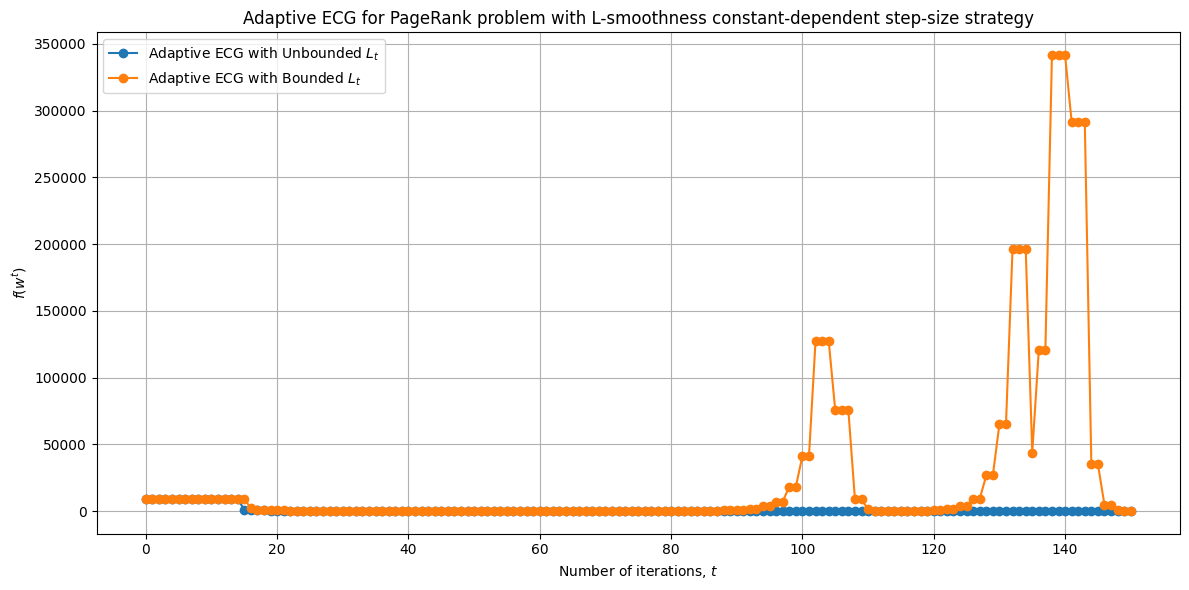

In [71]:
# Comparison of results
for algorithm in adaptive_algorithms:
    algorithm.solve(w0)
    plt.figure(figsize=(12, 6))
    values = [objective(w) for w, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.title(algorithm.label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
for algorithm in adaptive_algorithms:
    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

plt.title(
    r"Adaptive ECG for PageRank problem with L-smoothness constant-dependent step-size strategy"
)
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$f(w^t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

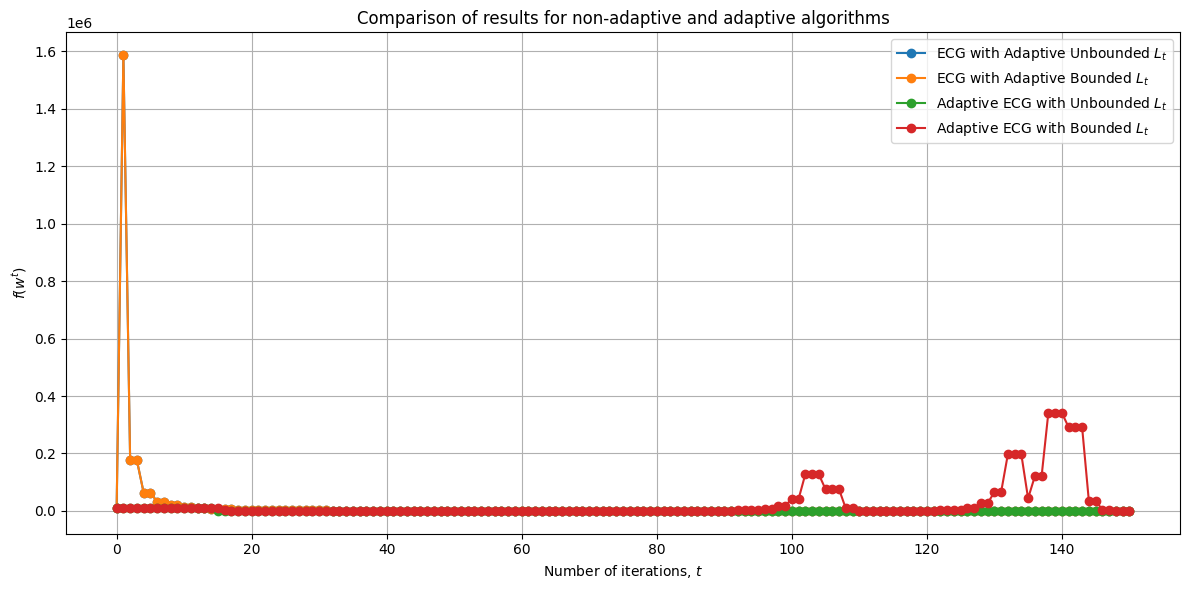

In [72]:
plt.figure(figsize=(12, 6))

for algorithm in (non_adaptive_algorithms + adaptive_algorithms):
    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker='o')

plt.title(r"Comparison of results for non-adaptive and adaptive algorithms")
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$f(w^t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()